In [1]:
%%capture
!pip install imagepig requests pillow --quiet
!pip install crewai crewai_tools 'crewai[tools]' --quiet
!pip install langchain-groq langchain requests --quiet

from crewai import Agent, Task, Crew, LLM, Process
from langchain_groq import ChatGroq
import os
import pickle
import requests
import re
import time

In [2]:
os.environ['GROQ_API_KEY'] = "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"

In [3]:
# Initialize the ChatGroq LLM
groq_llm = ChatGroq(
    model="groq/deepseek-r1-distill-llama-70b",
    api_key=os.getenv("GROQ_API_KEY")
)

groq_llm1 = ChatGroq(
    model="groq/llama-3.3-70b-versatile",
    api_key=os.getenv("GROQ_API_KEY")
)

groq_llm2 = ChatGroq(
    model="groq/mixtral-8x7b-32768",
    api_key=os.getenv("GROQ_API_KEY")
)

In [4]:
from crewai import Agent, Task, Crew

class StoryGeneratorCrew:
    def __init__(self):
        self.groq_llm2 = groq_llm2
        self.groq_llm = groq_llm
        self.groq_llm1 = groq_llm1 # Ensure you define your LLM before use

    def story_and_char_agent(self):
        return Agent(
            role="Story & Character Arc Generator",
            goal="""
                You are a master storyteller. Your task is to take a brief prompt from a user and expand it into a 1500-word immersive story that is rich in detail and world-building.
                Make sure that using this idea hundreds of pages can be written and have many different characters.
                Additionally, generate well-defined character arcs for all major characters, ensuring they have depth, motivations, and transformations over time.
                As well as generate a title that will cath audience attention.

                The generated story should:
                - Be engaging, with clear conflict, tension, and resolution.
                - Allow for further expansion (open-ended elements, world-building hooks).
                - Maintain consistency across characters and settings.
                - Use as many characters as possible (atleast 6)

                Character arcs should include:
                - Background & Personality
                - Strengths & Flaws
                - Initial State → Transformation → Final State

                **Output Format:**
                ```
                Title:
                ---------------------------
                [Story Title][atmax 4 words]

                Story:
                ---------------------------
                [1500-word immersive narrative]

                Characters:
                ---------------------------
                Character 1:
                - Name: [Character Name]
                - Background: [Where they come from, past experiences]
                - Personality: [Key traits, defining behaviors]
                - Strengths: [Unique skills, abilities]
                - Flaws: [Weaknesses, internal conflicts]
                - Arc Progression: [How they change over time]

                Character 2:
                [Same structure as Character 1]


                MAXIMUM 7 MAIN CHARACTERS
                ...
                ```
            """,
            backstory="""
                As a Story & Arc Agent, your mission is to craft compelling narratives and character journeys based on minimal user input.
                You ensure deep storytelling, character consistency, and an engaging, expandable world.
            """,
            verbose=True,
            llm=self.groq_llm1,  # Using the same LLM as your moderation agent
            max_iter=2,
        )

    def story_and_char_task(self, agent, input_data):
        return Task(
            description=f"""
                Generate a detailed, immersive 1500-word story and well-defined character arcs based on the provided prompt as well as a clickbaity title for the story .

                Prompt:
                ```
                {input_data}
                ```
                Guidelines:
                - Expand the prompt into a structured narrative with world-building and compelling conflict.
                - Ensure character consistency, depth, and transformation over time.
                - Keep the story open-ended for further elaboration.
                - Use as many characters as possible (atleast 6)

                Expected Output Format:
                ```
                Title:
                ---------------------------
                [Story Title]

                Story:
                ---------------------------
                [Generated 1500-word narrative]

                Characters:
                ---------------------------
                Character 1:
                - Name: [Character Name]
                - Background: [Where they come from, past experiences]
                - Personality: [Key traits, defining behaviors]
                - Strengths: [Unique skills, abilities]
                - Flaws: [Weaknesses, internal conflicts]
                - Arc Progression: [How they change over time]

                Character 2:
                [Same structure as Character 1]

                MAXIMUM 7 MAIN CHARACTERS
                ...
                ```
            """,
            agent=agent,
            expected_output="[Generated story and character arcs]",
            async_execution=False,
        )


# Instantiate and Run
story_crew = StoryGeneratorCrew()
agent1 = story_crew.story_and_char_agent()
task1 = story_crew.story_and_char_task(agent1, "A story about a roman warrior who dies in war")
crew1 = Crew(agents=[agent1],
             tasks=[task1],
             verbose=False,
              max_rpm=29,)

results1 = crew1.kickoff()


# Agent: Story & Character Arc Generator
## Task: 
                Generate a detailed, immersive 1500-word story and well-defined character arcs based on the provided prompt as well as a clickbaity title for the story .

                Prompt:
                ```
                A story about a roman warrior who dies in war
                ```
                Guidelines:
                - Expand the prompt into a structured narrative with world-building and compelling conflict.
                - Ensure character consistency, depth, and transformation over time.
                - Keep the story open-ended for further elaboration.
                - Use as many characters as possible (atleast 6)

                Expected Output Format:
                ```
                Title:
                ---------------------------
                [Story Title]

                Story:
                ---------------------------
                [Generated 1500-word narrative]

                Chara

In [5]:
import re

raw_text = results1.raw  # or just paste the string in raw_text directly

# Extract title
title_match = re.search(r'Title:\n[-]+\n(.+?)\n\nStory:', raw_text, re.DOTALL)
title = title_match.group(1).strip() if title_match else None

# Extract story
story_match = re.search(r'Story:\n[-]+\n(.+?)\n\nCharacters:', raw_text, re.DOTALL)
story = story_match.group(1).strip() if story_match else None


In [6]:
title

'"Beyond the Roman Grave"'

In [7]:
story

"The sun was setting over the battle-scarred landscape of Gaul, casting a golden glow over the carnage that lay before it. Marcus, a seasoned Roman warrior, stood tall amidst the chaos, his armor dented and his sword smeared with the blood of his enemies. He had fought in countless battles, but this one felt different. The enemy was fierce, and the Romans were outnumbered.\n\nAs the fight raged on, Marcus found himself face to face with a towering Gaulish warrior. The two clashed, their swords ringing out as they exchanged blow after blow. Marcus was a skilled fighter, but his opponent was relentless. In a moment of distraction, the Gaulish warrior landed a crushing blow, striking Marcus with a mighty force that sent him crashing to the ground.\n\nAs the Roman army retreated, Marcus was left behind, his body broken and battered. He lay there, watching as the Gauls claimed victory and the Romans fled in disarray. With his last breath, Marcus thought of his family, his friends, and his c

In [8]:
def thumbnail_prompt_extractor():
    return Agent(
        role="Thumbnail Prompt Extractor",
        goal="""
            Your task is to generate five compelling, stylistically distinct prompts for thumbnails based on the overall storyline.
            Each thumbnail should reflect the core idea and style implied by the user’s concept note while offering variation in layout,
            color schemes, and artistic direction. Do not give prompt that are either complex or requires two images in a single frame.

            **Expected Output Format:**
            ```
            Thumbnail Prompts:
            ---------------------------
            1. [First unique thumbnail prompt]
            2. [Second unique thumbnail prompt]
            3. [Third unique thumbnail prompt]
            4. [Fourth unique thumbnail prompt]
            5. [Fifth unique thumbnail prompt]
            ```
        """,
        backstory="""
            As a Thumbnail Prompt Extractor, you create engaging and visually distinct thumbnail descriptions
            that effectively capture the essence of a story.
        """,
        verbose=True,
        llm=groq_llm1,
        max_iter=2,
    )

def thumbnail_prompt_task(agent, story_data):
    return Task(
        description=f"""
            Generate five distinct and compelling prompts for thumbnails based on the given story.

            **Input Data:**
            - Overall Storyline: {story_data}

            **Guidelines:**
            - Ensure each prompt varies in artistic style, color scheme, and layout.
            - Reflect the core themes of the story.
            - Don not mention any character names.
            - It should lead to generation of some catchy images.
            - Try to use animated images if possible.(atmost 2)
            - Makes that that the description can be used to produce thumbnail images for videos.
            - Don't give prompt that requires inclusion of some kind of text in the image
            - Images should include atleat one character(almost 4 images)

            **Output Format:**
            ```

            **Expected Output Format:**
            ```
            Thumbnail Prompts:
            ---------------------------
            1. [First unique thumbnail prompt]
            2. [Second unique thumbnail prompt]
            3. [Third unique thumbnail prompt]
            4. [Fourth unique thumbnail prompt]
            5. [Fifth unique thumbnail prompt]
            ```
        """,
        agent=agent,
        expected_output="[Five unique thumbnail prompts]",
        async_execution=False,
    )

In [9]:
agent = thumbnail_prompt_extractor()
task = thumbnail_prompt_task(agent, story)
crew = Crew(agents=[agent],
             tasks=[task],
             verbose=False,
              max_rpm=29,)

results = crew.kickoff()

# Agent: Thumbnail Prompt Extractor
## Task: 
            Generate five distinct and compelling prompts for thumbnails based on the given story.

            **Input Data:**
            - Overall Storyline: The sun was setting over the battle-scarred landscape of Gaul, casting a golden glow over the carnage that lay before it. Marcus, a seasoned Roman warrior, stood tall amidst the chaos, his armor dented and his sword smeared with the blood of his enemies. He had fought in countless battles, but this one felt different. The enemy was fierce, and the Romans were outnumbered.

As the fight raged on, Marcus found himself face to face with a towering Gaulish warrior. The two clashed, their swords ringing out as they exchanged blow after blow. Marcus was a skilled fighter, but his opponent was relentless. In a moment of distraction, the Gaulish warrior landed a crushing blow, striking Marcus with a mighty force that sent him crashing to the ground.

As the Roman army retreated, Marcus was 

In [10]:
import re

def extract_thumbnail_prompts(results):
    """
    Extracts the five thumbnail prompts from a CrewOutput object.

    :param results: CrewOutput object containing the generated output.
    :return: A list of five thumbnail prompts.
    """

    # Ensure 'raw' output is present
    if not hasattr(results, "raw") or not results.raw:
        raise ValueError("CrewOutput object does not contain valid 'raw' output.")

    crew_text = results.raw.strip()

    # Regex to extract exactly five numbered thumbnail prompts
    thumbnail_pattern = r"\d+\.\s(.+)"  # Matches "1. some text" till end of line
    thumbnails = re.findall(thumbnail_pattern, crew_text)

    # Ensure we only return five entries
    return thumbnails[:5]  # Return only the first five thumbnails

# Example Usage
thumbnail_list = extract_thumbnail_prompts(results)
print(thumbnail_list)

['A hauntingly beautiful illustration of a lone Roman warrior standing atop a hill, overlooking a battle-scarred landscape at sunset, with a ghostly figure lurking in the background, set against a warm orange and pink color scheme.', 'A dramatic and intense depiction of a Roman soldier clashing swords with a fierce Gaulish warrior, with a dark and ominous background, and a splash of blood-red color to emphasize the brutality of the battle.', 'An animated thumbnail of a ghostly Roman warrior rising from the ground, with a swirling mist of smoke and a faint glow of light surrounding him, set against a dark and mysterious blue and purple color scheme.', 'A poignant and emotional illustration of a young priestess standing in a sacred grove, surrounded by candles and flowers, with a gentle and benevolent ghostly figure watching over her, set against a soft and calming green and blue color scheme.', 'An epic and action-packed thumbnail of a group of Roman soldiers charging into battle, with 

In [11]:
import requests
from base64 import b64decode
from io import BytesIO
from PIL import Image

# API Key (Replace with your actual key)
API_KEY = "3669e0a5-9dbb-4079-a8f2-8dc4c16380dd"

# Image Pig API endpoint
API_URL = "https://api.imagepig.com/"

def generate_image(prompt, negative_prompt="", format="JPEG", seed=None):
    """Generate an image using the Image Pig API."""
    payload = {
        "prompt": prompt,
        "negative_prompt": negative_prompt,
        "format": format
    }
    if seed is not None:
        payload["seed"] = seed

    headers = {"Api-Key": API_KEY}

    response = requests.post(API_URL, headers=headers, json=payload)

    if response.ok:
        img_data = b64decode(response.json()["image_data"])
        img = Image.open(BytesIO(img_data))
        return img
    else:
        print("Error:", response.json().get("error", "Unknown error"))
        return None

# User input
prompt = thumbnail_list[0]
negative_prompt = "None"

# Generate image
image = generate_image(prompt, negative_prompt)


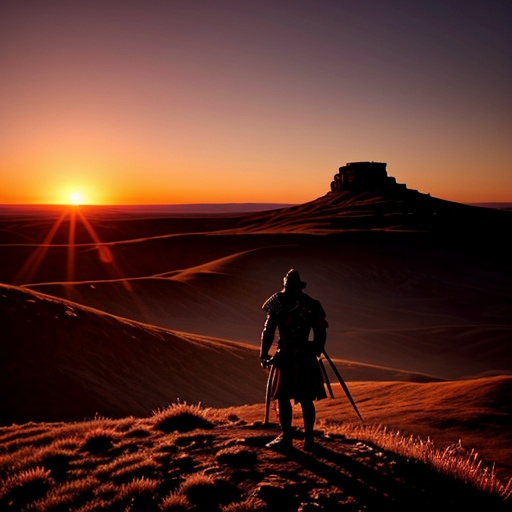

In [12]:
image

In [13]:
def title_generation_agent():
    return Agent(
        role="Creative Visual Style Generator",
        goal="""
            Analyze a given story and the prompt used to generate a YouTube thumbnail image.
            Using this context, suggest only the visual styling for a title text overlay.
            Do NOT generate or suggest the actual title text.

            Your output must include ONLY:
            - Font (must be a font available on Google Fonts: https://fonts.google.com/)
            - Font Color (hex code, chosen for contrast and thematic relevance, use bright colors)

            Avoid generic or overly common fonts like Roboto, Open Sans, or Arial.

            Prioritize fonts that are:
            - Quirky, bold, fun, or dramatic
            - Suitable for YouTube thumbnails aiming to grab attention
            - Visually striking and distinctive
            - Readable even at small sizes

            Ensure maximum visual impact and readability with the image's emotion and theme.
        """,
        backstory="""
            You are a creative visual stylist with a deep understanding of graphic design, color theory,
            and human psychology. You specialize in enhancing YouTube thumbnails with eye-catching,
            bold, and unconventional title styles that captivate viewers while remaining readable.
        """,
        verbose=True,
        llm=groq_llm,
        max_iter=2,
    )

def generate_thumbnail_title_task(agent, story, prompt):
    return Task(
        description=f"""
            Given the story and the prompt that was used to generate the thumbnail image,
            suggest styling details for a potential title text to be placed on the image.

            DO NOT generate or suggest the actual text of the title.

            Focus only on:
            - Font (must be a Google Fonts typeface: https://fonts.google.com/)
            - Font color (in hex code, use bright colors)

            The font should be bold, eye-catching, and full of personality — something visually unique
            that helps the thumbnail stand out. Avoid common fonts like Roboto or Open Sans.

            Think of fonts that are:
            - Quirky, playful, or dramatic
            - Stylized yet readable
            - Memorable and thematically aligned with the story’s emotion

            Inputs:
            Story:
            {story}

            Prompt used to generate the image:
            {prompt}

            Output format:
            {{
                "font": "Google Font name here",
                "font_color": "#HEXCODE"
            }}
        """,
        agent=agent,
        expected_output="A JSON object with only font and font_color.",
        async_execution=False,
    )


In [15]:
prompt = thumbnail_list[0]

In [16]:
agent = title_generation_agent()
task = generate_thumbnail_title_task(agent, story, prompt)
crew = Crew(agents=[agent],
             tasks=[task],
             verbose=False,
              max_rpm=29,)

results = crew.kickoff()

# Agent: Creative Visual Style Generator
## Task: 
            Given the story and the prompt that was used to generate the thumbnail image,
            suggest styling details for a potential title text to be placed on the image.

            DO NOT generate or suggest the actual text of the title.

            Focus only on:
            - Font (must be a Google Fonts typeface: https://fonts.google.com/)
            - Font color (in hex code, use bright colors)

            The font should be bold, eye-catching, and full of personality — something visually unique
            that helps the thumbnail stand out. Avoid common fonts like Roboto or Open Sans.

            Think of fonts that are:
            - Quirky, playful, or dramatic
            - Stylized yet readable
            - Memorable and thematically aligned with the story’s emotion

            Inputs:
            Story:
            The sun was setting over the battle-scarred landscape of Gaul, casting a golden glow over the

In [17]:
import re
match = re.search(r'{\s*"font":\s*".+?",\s*"font_color":\s*"#\w{6}"\s*}', results.raw)

if match:
    extracted_json = match.group()
    print(extracted_json)
else:
    print("No match found.")


{"font": "Cinzel", "font_color": "#FFD700"}


In [18]:
import json
import requests
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO

# Your variables
image = image  # or already loaded PIL image

# Parse the JSON
style = json.loads(extracted_json)
font_name = style["font"]
font_color = style["font_color"]

# Step 1: Get the Google Fonts CSS to find the TTF URL
css_url = f"https://fonts.googleapis.com/css2?family={font_name.replace(' ', '+')}&display=swap"
headers = { "User-Agent": "Mozilla/5.0" }  # Google Fonts blocks requests without a User-Agent
css_response = requests.get(css_url, headers=headers)

# Step 2: Extract the font file URL (TTF or WOFF2)
import re
ttf_url_match = re.search(r'url\((https://[^)]+\.ttf)\)', css_response.text)
if not ttf_url_match:
    raise Exception(f"Could not find a TTF font for {font_name}")

ttf_url = ttf_url_match.group(1)

# Step 3: Download the TTF
font_response = requests.get(ttf_url)
font_bytes = BytesIO(font_response.content)

# Step 4: Use PIL to draw the title
font_size = 35 # You can make this dynamic based on image size
font = ImageFont.truetype(font_bytes, font_size)
draw = ImageDraw.Draw(image)

# Center-bottom
bbox = draw.textbbox((0, 0), title, font=font)
text_width = bbox[2] - bbox[0]
text_height = bbox[3] - bbox[1]

image_width, image_height = image.size
x = (image_width - text_width) // 2
y = image_height - text_height - 75  # 30px margin from bottom


draw.text((x, y), title, font=font, fill=font_color)



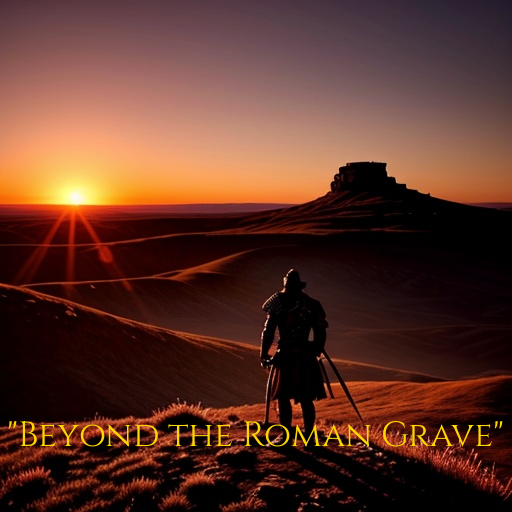

In [19]:
image